In [ ]:
# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
# os
import os
# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# tf
import tensorflow as tf
# keras
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Layer, GRU, LSTM, SimpleRNN, Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.regularizers import l1,l2

In [ ]:
#!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
# Import btc
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Make pd df
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NN Time Series Project/data/btc.csv')

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop extraneous columns
df.drop(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)'], axis = 1, inplace = True)
# Drop bottom 3m rows and top 800k
df.drop(df.index[:3000000], axis = 0, inplace = True)
df.drop(df.index[4000000:], axis = 0, inplace = True)
# Reset index; drop column
df.reset_index(drop = True, inplace = True)
# Backfill na's
df.fillna(method = 'backfill', inplace = True)

In [ ]:
# RNN target/features
features = ['Weighted_Price']
target = 'Weighted_Price'

In [ ]:
# Split train sets
train_weight = 0.8
df_split = int( len(df) * train_weight )

train = df.iloc[:df_split]
test = df.iloc[df_split:]

In [ ]:
# Scaling parameters
mu = float( train[features].mean() )
sigma = float( train[features].std() )

# Scale data
train = train[features].apply( lambda x: (x - mu) / sigma )
test = test[features].apply( lambda x: (x - mu) / sigma )

In [ ]:
'''
Function for reshaping data into one-step ahead time series prediction format
    value: feature value to be lagged
    n_steps: number of steps/sequence length
    n_steps_ahead: forecasting horizon
'''

def get_lagged_features(value, n_steps, n_steps_ahead):
    lag_list = []
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append( value.shift(lag) )
    return pd.concat(lag_list, axis = 1)

In [ ]:
# Number of steps ahead
n_steps_ahead = n_steps = 5

# Transform training input and output data
col_ords = []
for i in range(n_steps):
    for j in range(len(features)):
        col_ords.append(i + j * n_steps)

x_train_list = []
for f in features:
    x_train_reg = get_lagged_features(train, n_steps, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis = 1)
        
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape( x_train_reg.values, ( x_train_reg.shape[0], int( x_train_reg.shape[1] / len(features)), len(features) ) )
y_train_reg = np.reshape( y_train_reg, (y_train_reg.shape[0], 1, 1))

In [ ]:
# Transform test input and output data
x_test_list = []
for f in features:
    x_test_reg = get_lagged_features(test, n_steps, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis = 1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape( x_test_reg.values, ( x_test_reg.shape[0], int( x_test_reg.shape[1] / len(features)), len(features) ) )
y_test_reg = np.reshape( y_test_reg, (y_test_reg.shape[0], 1, 1))

In [ ]:
# Verify tensor shapes
#   value 1: # of observations
#   value 2: sequence length, or number of lags
#   value 3: dimension of each element in the sequence (x) or output vector (y): this is univariate time analysis, so the dimension of I/O is 1

print(x_train_reg.shape)
print(y_train_reg.shape)
print(x_test_reg.shape)
print(y_test_reg.shape)

(1485892, 5, 1)
(1485892, 1, 1)
(371467, 5, 1)
(371467, 1, 1)


In [ ]:
# Append lagged lists to train data
x_train_reg = pd.concat(x_train_list, axis = 1)
# Reshape
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape( x_train_reg.values, ( x_train_reg.shape[0], int(x_train_reg.shape[1] / len(features)), len(features) ) )

In [ ]:
# Append lagged lists to test data
x_test_reg = pd.concat(x_test_list, axis = 1)
# Reshape
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape( x_test_reg.values, ( x_test_reg.shape[0], int(x_test_reg.shape[1] / len(features)), len(features) ) )

In [ ]:
# Custom activation function
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
# Model structures
def _sRNN(data = x_train_reg, n_units = 10, l1_reg = 0.0001, seed = 0, optim = 'adam'):
    model = Sequential()
    model.add( 
        SimpleRNN(n_units,
                  activation = 'swish', 
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (data.shape[1], data.shape[-1]),
                  unroll = True,
                  stateful = False) )  
    model.add(
        Dense(1, 
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _dropout(data = x_train_reg, n_units = 8, l1_reg = 0.0001, seed = 0, optim = 'adam', dropout = 0.1):
    model = Sequential()
    model.add(
        Dropout(rate = dropout, 
                input_shape = (data.shape[1], data.shape[-1]),
                name = 'Dropout_A') )
    model.add( 
        SimpleRNN(n_units,
                  activation = 'swish', 
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (data.shape[1], data.shape[-1]),
                  unroll = True,
                  stateful = False,
                  name = 'RNN_A') )
    model.add(
        Dense(1,
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg),
              name = 'Dense_A') )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

In [ ]:
# NN models
params = {
    'srnn_1000': {'model':'', 'function':_sRNN, 'H':10, 'l1_reg':0.0001, 'batch_size':1000, 'label':'sRNN A', 'history':'', 'cv_results':''},
    'srnn_1200': {'model':'', 'function':_sRNN, 'H':10, 'l1_reg':0.0001, 'batch_size':1500, 'label':'sRNN B', 'history':'', 'cv_results':''},
    'srnn_1400': {'model':'', 'function':_sRNN, 'H':10, 'l1_reg':0.0001, 'batch_size':2000, 'label':'sRNN C', 'history':'', 'cv_results':''},
    'd_srnn_1000': {'model':'', 'function':_dropout, 'H':10, 'l1_reg':0.0001, 'batch_size':1000, 'label':'Dropout sRNN A', 'history':'', 'cv_results':''},
    'd_srnn_1200': {'model':'', 'function':_dropout, 'H':10, 'l1_reg':0.0001, 'batch_size':1500, 'label':'Dropout sRNN B', 'history':'', 'cv_results':''},
    'd_srnn_1400': {'model':'', 'function':_dropout, 'H':10, 'l1_reg':0.0001, 'batch_size':2000, 'label':'Dropout sRNN C', 'history':'', 'cv_results':''}
}

In [ ]:
# Parameters
n_epoches = 50

In [ ]:
# Train cross-validated NN model
for k in params.keys():
    tf.random.set_seed(0)
    model = params[k]['function'](data = x_train_reg, n_units = params[k]['H'], 
                                  l1_reg = params[k]['l1_reg'])
    params[k]['history'] = model.fit(x_train_reg, y_train_reg, epochs = n_epoches, 
                                     batch_size = params[k]['batch_size'], shuffle = False )
    params[k]['model'] = model

Epoch 1/50
1486/1486 [==============================] - 5s 3ms/step - loss: 0.2207
Epoch 2/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0034
Epoch 3/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 4/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0011
Epoch 5/50
1486/1486 [==============================] - 4s 3ms/step - loss: 9.8004e-04
Epoch 6/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0010
Epoch 7/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0012
Epoch 8/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0014
Epoch 9/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0014
Epoch 10/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 11/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 12/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.00

In [ ]:
# Prediction on test and train data with NN models
for k in params.keys():
    step_lag = n_steps + n_steps - 1
    model = params[k]['model']
    model.summary()

    params[k]['MSE_train'] = mean_squared_error(train[features][step_lag:], model.predict(x_train_reg, verbose = 1))
    params[k]['predict'] = model.predict(x_test_reg, verbose = 1)
    params[k]['MSE_test'] = mean_squared_error(test[features][step_lag:], params[k]['predict'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, 10)                120       
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
11609/11609 [==============================] - 16s 1ms/step
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, 10)                120       
                                                                 
 dense_16 (Dense)            (None, 1)                 11        
                                      

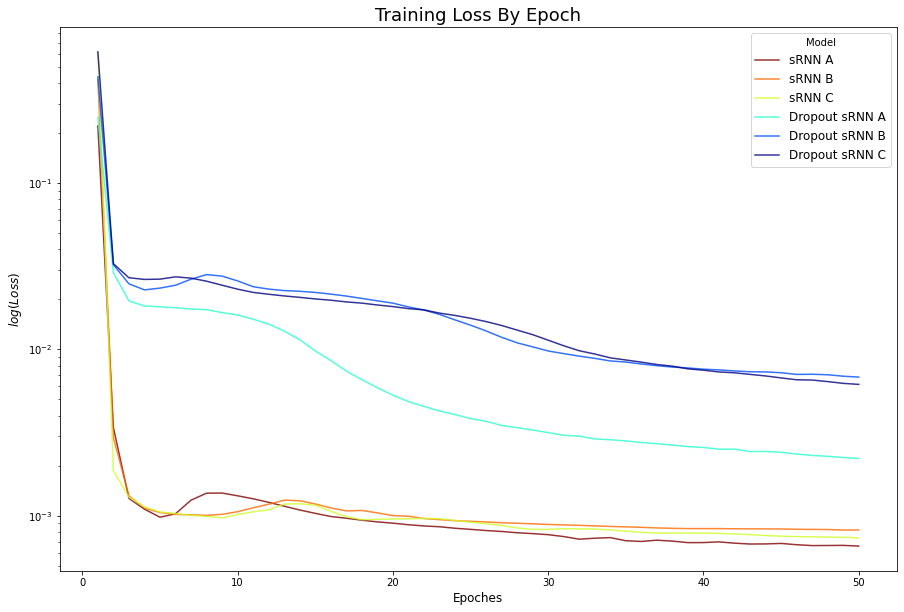

In [ ]:
# Plot training loss by epoch
fig = plt.figure(figsize = (15, 10))
epoch_arr = np.arange(1, n_epoches + 1)
colors = pl.cm.jet(np.linspace(1, 0, 6))
i = 0

for k in params.keys():
    plt.plot(epoch_arr, params[k]['history'].history['loss'], color = colors[i], label = params[k]['label'], alpha = 0.8)
    i += 1
    
plt.yscale('log')
plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Epoches', fontsize = 12)
plt.ylabel('$log(Loss)$', fontsize = 12)
plt.title('Training Loss By Epoch', fontsize = 18)

plt.show()

Text(0.5, 1.0, 'Untrimmed Test Residual ($\\hat{Y_i} - Y_i$)')

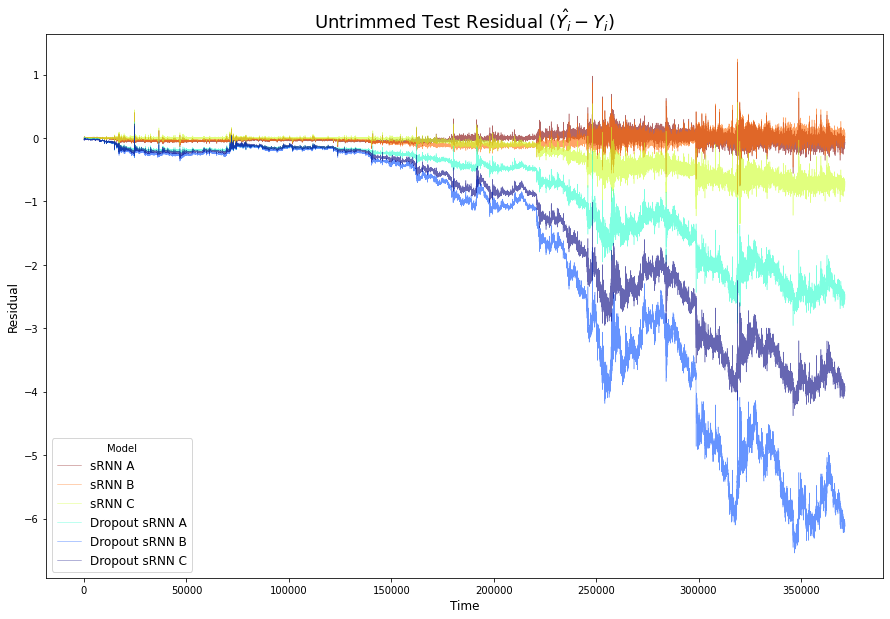

In [ ]:
# Plot untrimmed residuals for test set
fig = plt.figure(figsize = (15, 10))
_x = np.arange(0, len(y_test_reg))
colors = pl.cm.jet(np.linspace(1, 0, 6))
i = 0

for k in params.keys():
    residual = params[k]['predict'] - y_test_reg
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.6, linewidth = 0.5)
    i += 1

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Untrimmed Test Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

In [ ]:
print('Model Errors:')

for k in params.keys():
    print('Model: ' + params[k]['label'])
    print('   Train MSE = ' + str(params[k]['MSE_train']))
    print('   Test MSE = ' + str(params[k]['MSE_test']))
    print()

Model Errors:
Model: sRNN A
   Train MSE = 0.0015781198338446416
   Test MSE = 0.002986948217400889

Model: sRNN B
   Train MSE = 0.0015492882573798121
   Test MSE = 0.00473494861684806

Model: sRNN C
   Train MSE = 0.0005953244422559735
   Test MSE = 0.12139076406472618

Model: Dropout sRNN A
   Train MSE = 0.01708214560640988
   Test MSE = 1.3175582439089888

Model: Dropout sRNN B
   Train MSE = 0.03657705259562006
   Test MSE = 7.550348387328385

Model: Dropout sRNN C
   Train MSE = 0.031061857640083824
   Test MSE = 3.4739605602283605

